In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools

In [2]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file

In [3]:
from networkx.algorithms.community import greedy_modularity_communities
import community

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [5]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [6]:
def collaborative_metrics_of_graph(graph):
    """
    Returns the following metrics:
    - number of nodes
    - number of edges
    - number of isolated authors
    - percentage of isolated authors
    - number of connected components
    - size of the largest connected component
    - average degree
    - clustering coefficients
    - modularity
    """
    num_nodes = nx.number_of_nodes(graph)
    num_edges = nx.number_of_edges(graph)
    isolated_nodes = len(list(nx.isolates(graph)))
    percentage_isolated_nodes = np.round(isolated_nodes / num_nodes, 3) * 100
    number_connected_components = nx.number_connected_components(graph)
    size_of_largest_cc = len(max(nx.connected_components(graph), key=len))

    degree_distribution = sorted([d for n, d in graph.degree()], reverse=True)
    av_degree = np.round(np.mean(degree_distribution), 3)

    clustering_coeff = round(nx.average_clustering(graph), 3)

    try:
        number_of_communities = len(list(greedy_modularity_communities(graph)))
    except ZeroDivisionError:
        number_of_communities = "-"

    communities = community.best_partition(graph)
    try:
        modularity = community.modularity(partition=communities, graph=graph)
    except ValueError:
        modularity = "-"

    metrics = {
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "# Isolated nodes": isolated_nodes,
        "% Isolated nodes": round(percentage_isolated_nodes, 3),
        "# Connected components": number_connected_components,
        "Size of largest component": size_of_largest_cc,
        "Av. degree": av_degree,
        "Clustering coeff": clustering_coeff,
        "# Communities": number_of_communities,
        "Modularity": modularity,
    }

    return metrics, degree_distribution



**Initial Results**

In [7]:
df = pd.read_csv("../data/prisoners_dilemma_articles_meta_data_clean.csv")

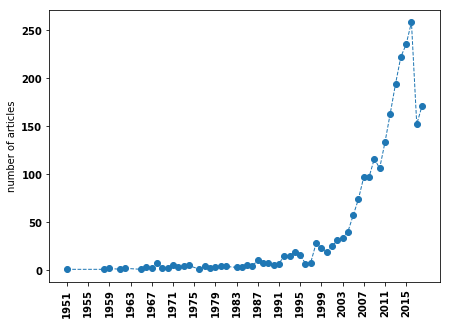

In [10]:
total = len(df["unique_key"].unique())

yearly = (
    df.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
)

fig = plt.figure(figsize=(7, 5))

plt.plot(yearly.index, yearly.values, "--o", zorder=1, linewidth=1)
plt.xticks(np.arange(min(yearly.index), 2018, step=4), rotation=90)

plt.ylabel("number of articles");
# plt.title("Articles per Year");

In [9]:
from scipy import optimize


def func(x, a, b, c):
    return a * np.exp(-b * np.array(x)) + c

In [10]:
y = yearly[1980:2016].values
x = [i for i,_ in enumerate(y)]

params, params_covariance = optimize.curve_fit(func, x, y, p0=[0, 0, 0])

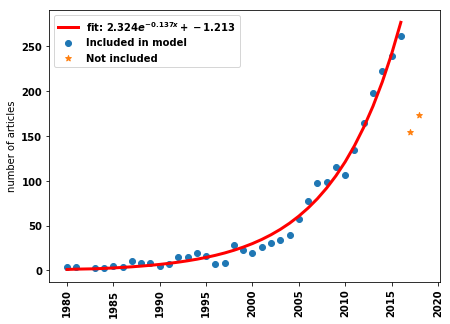

In [11]:
plt.figure(figsize=(7, 5))
plt.scatter(
    yearly[1980:2016].index,
    y,
    zorder=1,
    linewidth=1,
    label="Included in model",
)
plt.plot(
    yearly[1980:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.scatter(
    yearly[2017:2018].index,
    yearly[2017:2018].values,
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
)
plt.xticks(rotation=90)
plt.legend(loc="best")

plt.ylabel("number of articles");

In [12]:
xn = range(37, 42)
forecasting = [round(func(x_v, *params)) for x_v in xn]

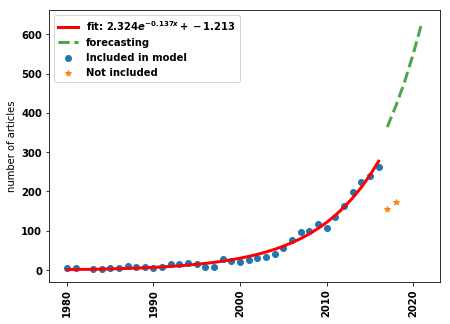

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(
    yearly[1980:2016].index,
    y,
    zorder=1,
    linewidth=1,
    label="Included in model",
)
plt.plot(
    yearly[1980:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.plot(
    range(2017, 2022),
    forecasting,
    label="forecasting",
    color="green",
    zorder=2,
    linewidth=3,
    alpha=0.7,
    linestyle="--",
)
plt.scatter(
    yearly[2017:2018].index,
    yearly[2017:2018].values,
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
)

plt.xticks(rotation=90)

plt.legend(loc="best")

plt.ylabel("number of articles");


In [14]:
number_of_authors_per_paper = df[['unique_key', 'author']].drop_duplicates().groupby(['unique_key']).count()
number_of_authors_per_paper.reset_index(level=0, inplace=True)

In [15]:
number_of_authors_per_paper = number_of_authors_per_paper.merge(df[['unique_key', 'date']].drop_duplicates(), on='unique_key')

In [16]:
number_of_authors_per_paper = number_of_authors_per_paper[number_of_authors_per_paper['author'] > 1]

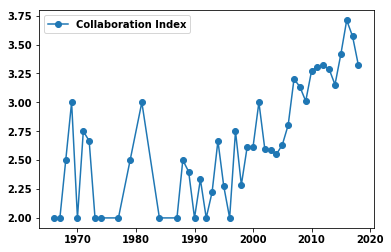

In [17]:
plt.plot(number_of_authors_per_paper.groupby('date').mean(),
         '-o', label='Collaboration Index');
plt.legend();

**Topics**

In [18]:
topics = pd.read_csv('../data/prisoners_dilemma_meta_data_with_topics.csv', index_col=0)

In [19]:
documents_of_topic = pd.DataFrame()

documents_of_topic_grpd = topics.groupby('Dominant_Topic')

for i, grp in documents_of_topic_grpd:
    documents_of_topic = pd.concat([documents_of_topic, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)
documents_of_topic.reset_index(drop=True, inplace=True)
documents_of_topic = documents_of_topic[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','title', 'date']]

In [20]:
documents_of_topic

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title,date
0,0.0,0.6220,"model, theory, system, problem, provide, propo...",Gaming and price spikes in electric power mark...,2002.0
1,1.0,0.6948,"cooperation, network, population, evolutionary...",Defectors Can Create Conditions That Rescue Co...,2015.0
2,2.0,0.6440,"game, strategy, player, agent, dilemma, play, ...",Fingerprinting: Visualization and Automatic An...,2008.0
3,3.0,0.7268,"social, behavior, group, individual, human, st...",Facing Aggression: Cues Differ for Female vers...,2012.0


In [21]:
yearly = (
        topics.groupby(["Dominant_Topic", "date"]).size().reset_index().groupby("date").size()
    )

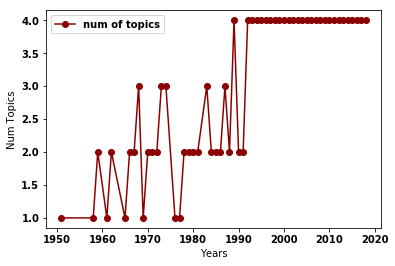

In [22]:
fig = plt.subplots()
plt.plot(yearly, '-o', color='darkred', label='num of topics');

plt.legend();
plt.ylabel("Num Topics")
plt.xlabel("Years");

In [23]:
groups = ['A', 'B', 'C', 'D', 'E']

where (maybe):
   - A: social problems that are a pd
   - B: ipd with humans
   - C: ipd with computers
   - D: modelling situations as ipd
   - E: evolutionary dynamics

In [24]:
years = sorted(topics.date.unique())
selected_num_topics = 4

In [25]:
counts = []
for year in years:
    specific_year = topics[topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

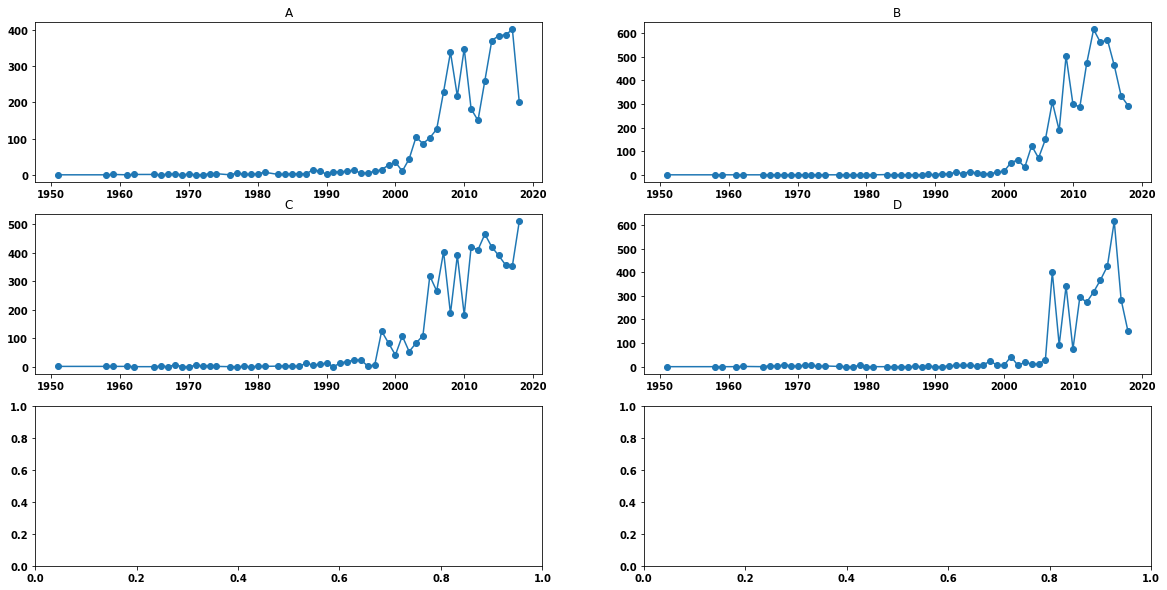

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(years, [c[i] for c in counts], '-o',);
    axes[index].set_title(groups[i])

In [27]:
subset_of_years = years[45:]

In [28]:
counts = []
for year in subset_of_years:
    specific_year = topics[topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

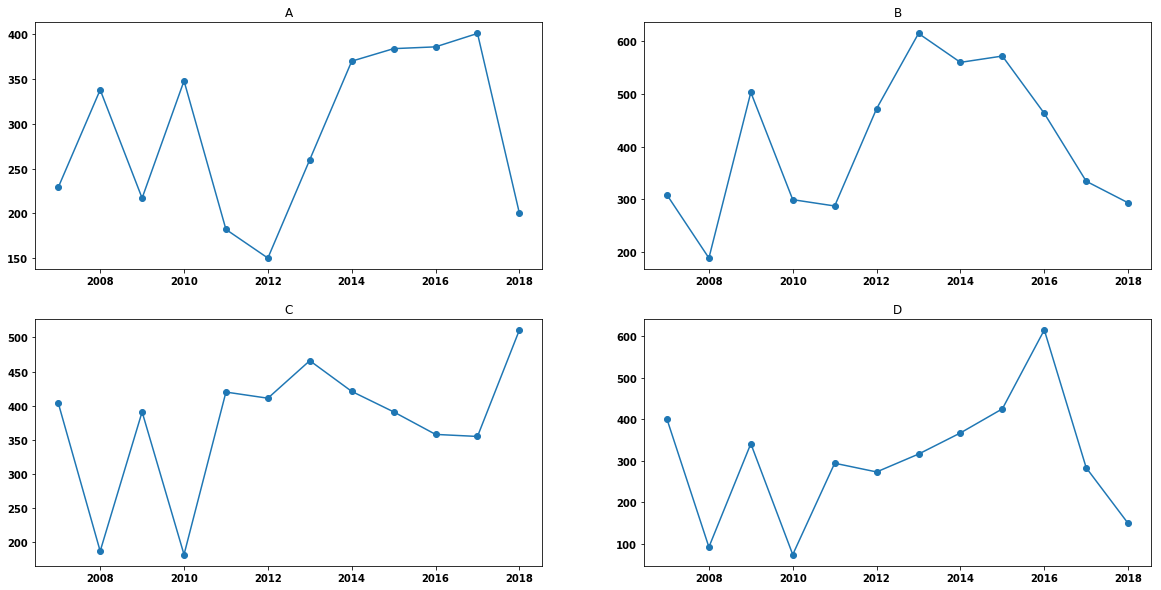

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(subset_of_years, [c[i] for c in counts], '-o');
    axes[index].set_title(groups[i])

**Co authorship Network**

Measures regarding the network + the table for the evolution of the network over time and the centralinity measures. All these for both the network overall and the main cluster (so in total 2 tables and 5 bar plots)

**Network for topic**

In [30]:
number_of_topics = 4

In [31]:
per_topic = [topics[["Dominant_Topic", 'author', 'unique_key']][topics['Dominant_Topic'] == i].drop_duplicates()
             for i in range(4)]

In [32]:
per_topic[0].author = per_topic[0].author.str.lower()

In [33]:
graphs = []
for top_df in per_topic:
    edges = []
    keys = top_df.unique_key
    for key in keys:
        authors = top_df[top_df['unique_key'] == key]['author'].values
        edges += itertools.combinations(authors, 2) 
        
    G = nx.Graph()
    G.add_edges_from(edges)
    graphs.append(G)

In [34]:
cumulative_metrics = [collaborative_metrics_of_graph(G) for G in graphs]

In [35]:
cumulative_metrics[0][0]

{'# Nodes': 1136,
 '# Edges': 2232,
 '# Isolated nodes': 0,
 '% Isolated nodes': 0.0,
 '# Connected components': 335,
 'Size of largest component': 32,
 'Av. degree': 3.93,
 'Clustering coeff': 0.704,
 '# Communities': 335,
 'Modularity': 0.9414206523554416}

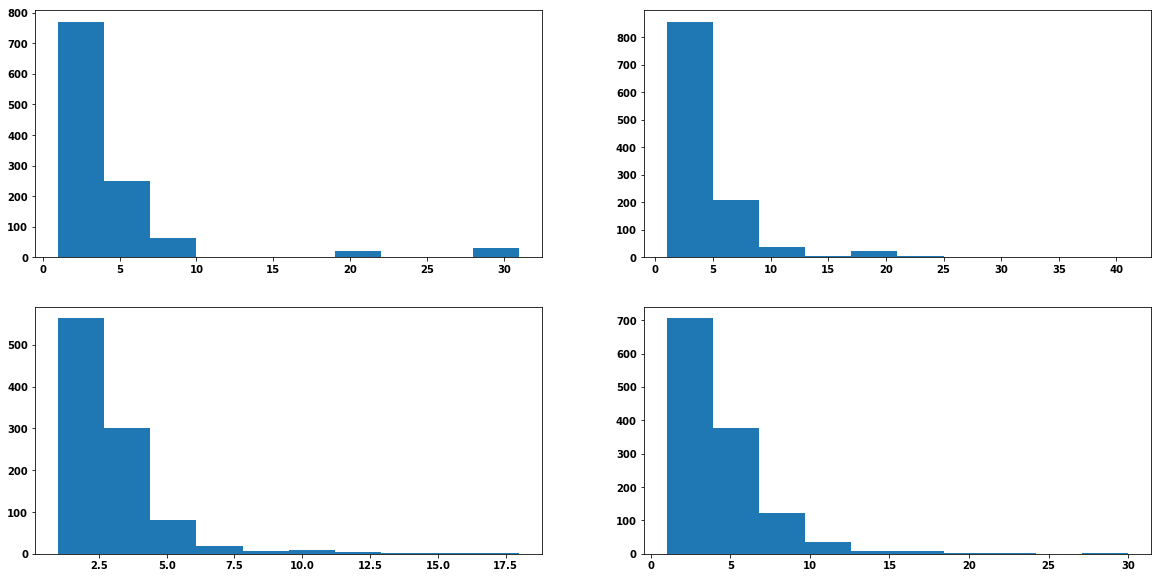

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].hist(cumulative_metrics[i][1]);

**centrality**

In [37]:
betweeness = [
    sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]

In [38]:
betweeness_values = [[centrality[-1] for centrality in betweeness_for_topic]
                     for betweeness_for_topic in betweeness]

In [39]:
closeness = [
    sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]

In [40]:
closeness_values = [[centrality[-1] for centrality in closeness_for_topic]
                     for closeness_for_topic in closeness]

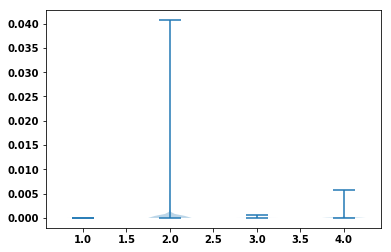

In [41]:
plt.violinplot(betweeness_values);

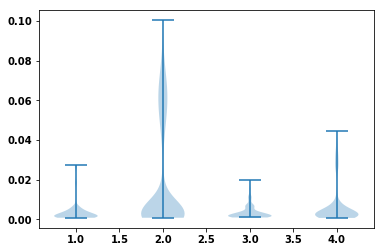

In [42]:
plt.violinplot(closeness_values);